# Computer Vision
This notebook includes some examples of techniques used to analyze images - which is a common requirement in AI solutions.

## Manipulating Images
As far as computers are concerned, images are simply numerical data representations. You can use statistical techniques to manipulate and analyze the numerical properties of images.

### Load an Image
Let's start by loading a JPG file and examining its properties. Run the following cell to load and display an image.

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
 75  125k   75 97476    0     0  62404      0  0:00:02  0:00:01  0:00:01 62404
100  125k  100  125k    0     0  75393      0  0:00:01  0:00:01 --:--:-- 75393


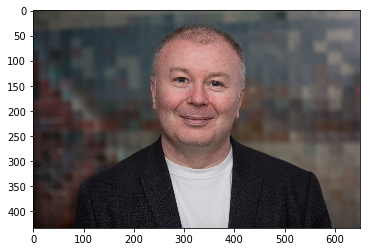

In [ ]:
from matplotlib.pyplot import imshow
from PIL import Image
import numpy as np
%matplotlib inline

!curl https://raw.githubusercontent.com/MicrosoftLearning/AI-Introduction/master/files/graeme2.jpg -o img.jpg

i = np.array(Image.open('img.jpg'))
imshow(i)

### Examine Numerical Properties of the Image
You can clearly see that this is an image, but how does the computer interpret the data?

Run the cell below to determine the data type of the image.

In [ ]:
type(i)

numpy.ndarray

The image data is actually stored as a multi-dimensional array.

Let's see what data type the array elements are:

In [ ]:
i.dtype

dtype('uint8')

OK, so the array consists of 8-bit integer values. In other words, whole numbers between 0 and 255.

Now let's examine the shape of the array:

In [ ]:
i.shape

(433, 650, 3)

So the image data is a three dimensional 433 x 650 x 3 array.

This is a RGB color JPG image sized 433 x 650 pixels. The image includes pixel values for red, green, and blue color channels.

To keep things simple, let's convert the image to a greyscale image so we only have one color channel dimension to deal with:

(433, 650)

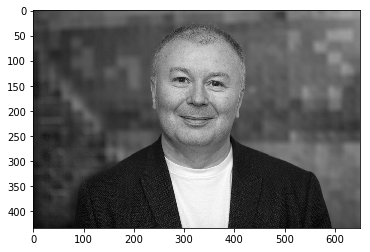

In [ ]:
import skimage.color as sc

i_mono = sc.rgb2gray(i)
imshow(i_mono, cmap='gray')
i_mono.shape

### View Pixel Value Distributions
Let's look at the distribution of pixel values in the image. Ideally, the image should have relatively even distribution of values, indicating good contrast and making it easier to extract analytical information.

An easy way to check this is to plot a histogram.

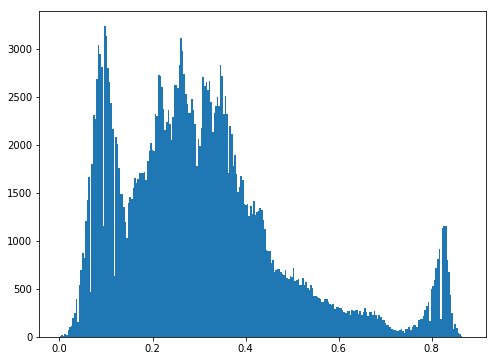

In [ ]:
def im_hist(img):
    import matplotlib.pyplot as plt
    fig = plt.figure(figsize=(8, 6))
    fig.clf()
    ax = fig.gca()
    ax.hist(img.flatten(), bins = 256)
    plt.show()

im_hist(i_mono)

Another useful way to visualize the statistics of an image is as a cumulative distribution function (CDF) plot. Ideally, this should result in a fairly straight diagonal line.

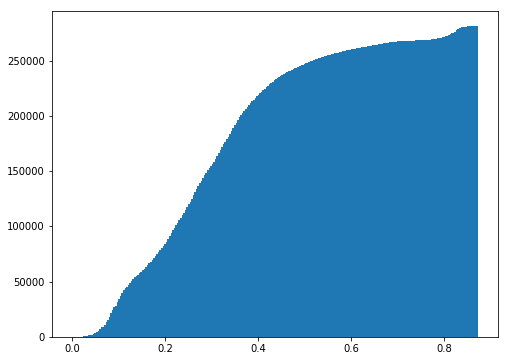

In [ ]:
def im_cdf(img):
    import matplotlib.pyplot as plt
    fig = plt.figure(figsize=(8, 6))
    fig.clf()
    ax = fig.gca()
    ax.hist(img.flatten(), bins = 256, cumulative=True)
    plt.show()

im_cdf(i_mono)

The histogram and CDF for our image show pretty uneven distribution. Ideally we should equalize the values in the image to improve its analytical value.

### Equalize the Image
Histogram equalization is often used to improve the statistics of images. In simple terms, the histogram equalization algorithm attempts to adjust the pixel values in the image to create a more uniform distribution. The code in the cell below uses the  **exposure.equalize_hist** method from the **skimage** package to equalize the image.  

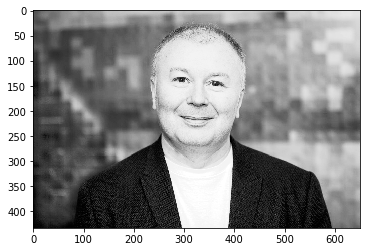

In [ ]:
from skimage import exposure

i_eq = exposure.equalize_hist(i_mono)
imshow(i_eq, cmap='gray')

Now let's see what that's done to the histogram and CDF plots:

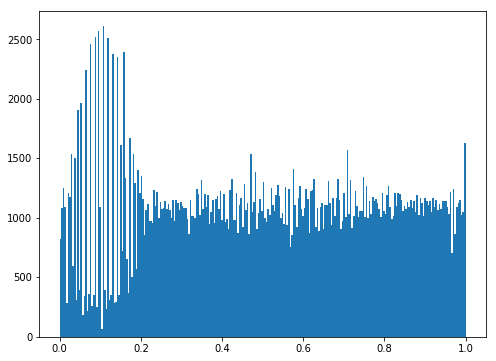

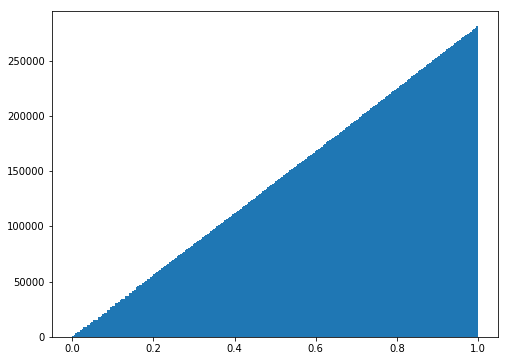

In [ ]:
im_hist(i_eq)
im_cdf(i_eq)

The pixel intensities are more evenly distributed in the equalized image.

## Denoising with Filters

Often images need to be cleaned up to remove "salt and pepper" noise.

### Add Some Random Noise
Let's add some random noise to our image - such as you might see in a photograph taken in low light or at a low resolution.

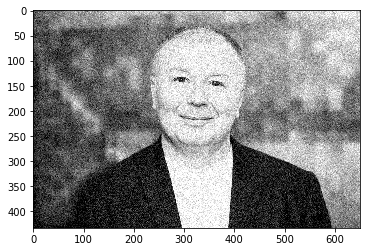

In [ ]:
import skimage
i_n = skimage.util.random_noise(i_eq)
imshow(i_n, cmap="gray")

### Using a Gaussian Filter
A Gaussian filter applies a weighted average (mean) value for pixels based on the pixels that surround them.

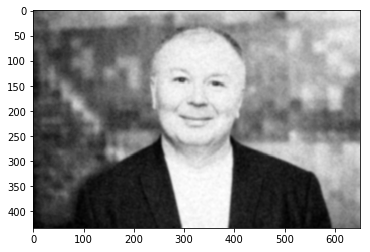

In [ ]:
def gauss_filter(im, sigma = 2):
    from scipy.ndimage.filters import gaussian_filter as gf
    import numpy as np
    return gf(im, sigma = sigma)
i_g = gauss_filter(i_n)
imshow(i_g, cmap="gray")

### Using a Median Filter
The Gaussian filter results in a blurred image - we could try a median filter, which as the name suggests applies the median value to pixels based on the pixels around them.

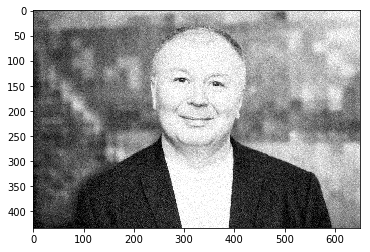

In [ ]:
def med_filter(im, size = 2):
    from scipy.ndimage.filters import median_filter as mf
    import numpy as np
    return mf(im, size = size)
i_m = med_filter(i_n)
imshow(i_m, cmap="gray")

### Extract Features
Now that we've done some initial processing of the image to improve its statistics for analysis, we can start to extract features from it.
#### Sobel Edge Detection
As a first step in extracting features, you will apply the Sobel edge detection algorithm. This finds regions of the image with large gradient values in multiple directions. Regions with high omnidirectional gradient are likely to be edges or transitions in the pixel values.

The code in the cell below applies the Sobel algorithm to the median filtered image, using these steps:

    1. Convert the color, rgb, image to grayscale (in this case, the image is already grayscale - but you should always do this because using a grayscale image simplifies the gradient calculation since it is two dimensional.
    2. Computer the gradient in the x and y (horizontal and vertical) directions.
    3. Compute the magnitude of the gradient.
    4. Normalize the gradient values.


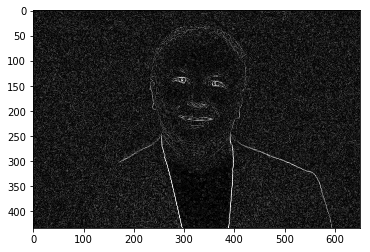

In [ ]:
def edge_sobel(image):
    from scipy import ndimage
    import skimage.color as sc
    import numpy as np
    image = sc.rgb2gray(image) # Convert color image to gray scale
    dx = ndimage.sobel(image, 1)  # horizontal derivative
    dy = ndimage.sobel(image, 0)  # vertical derivative
    mag = np.hypot(dx, dy)  # magnitude
    mag *= 255.0 / np.amax(mag)  # normalize (Q&D)
    mag = mag.astype(np.uint8)
    return mag

i_edge = edge_sobel(i_m)
imshow(i_edge, cmap="gray")

Now let's try with the more blurred gaussian filtered image.

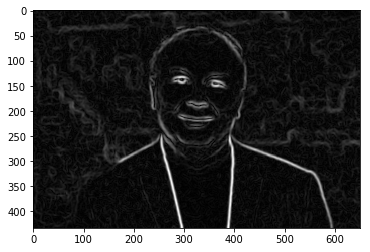

In [ ]:
i_edge = edge_sobel(i_g)
imshow(i_edge, cmap="gray")

Note that the lines are more pronounced. Although a gaussian filter makes the image blurred to human eyes, this blurring can actually help accentuate contrasting features.

#### Harris Corner Detection
Another example of a feature extraction algorithm is corner detection. In simple terms, the Harris corner detection algorithm locates regions of the image with large changes in pixel values in all directions. These regions are said to be corners. The Harris corner detector is paired with the **corner_peaks** method. This operator filters the output of the Harris algorithm, over a patch of the image defined by the span of the filters, for the most likely corners.

[[139 296]
 [146 362]]


'Done'

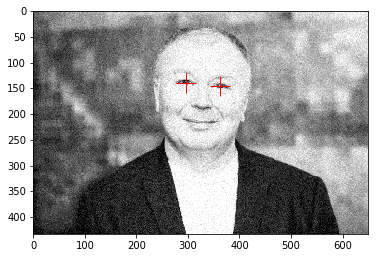

In [ ]:
# Function to apply the Harris corner-detection algorithm to an image
def corner_harr(im, min_distance = 20):
    from skimage.feature import corner_harris, corner_peaks
    mag = corner_harris(im)
    return corner_peaks(mag, min_distance = min_distance)

# Find the corners in the median filtered image with a minimum distance of 20 pixels
harris = corner_harr(i_m, 20)

print (harris)

# Function to plot the image with the harris corners marked on it
def plot_harris(im, harris, markersize = 20, color = 'red'):
    import matplotlib.pyplot as plt
    import numpy as np
    fig = plt.figure(figsize=(6, 6))
    fig.clf()
    ax = fig.gca()
    ax.imshow(np.array(im).astype(float), cmap="gray")
    ax.plot(harris[:, 1], harris[:, 0], 'r+', color = color, markersize=markersize)
    return 'Done'

plot_harris(i_m, harris)

In [ ]:
harris[:,1]

array([296, 362], dtype=int64)

The corner detection algorithm has identified the eyes in the image.